## Agentic RAG

In [24]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,RemoveMessage
from typing import Annotated, Sequence, TypedDict, Literal, Any
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_ibm import ChatWatsonx
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel
from langchain.callbacks.base import BaseCallbackHandler
import time
import os
from langchain_core.tools import tool
from langchain_core.prompts import HumanMessagePromptTemplate,ChatMessagePromptTemplate,ChatPromptTemplate, MessagesPlaceholder,SystemMessagePromptTemplate
from langchain.schema import SystemMessage
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

In [25]:
!pip freeze > requirements.txt

In [ ]:
model_llama4="meta-llama/llama-4-maverick-17b-128e-instruct-fp8"
model_granite_vision="ibm/granite-vision-3-2-2b"

from dotenv import load_dotenv

load_dotenv(override=True)

llm_vision = ChatWatsonx(model_id=model_granite_vision,project_id="<PROJECT-ID>",url="https://us-south.ml.cloud.ibm.com",apikey="<API-KEY>")

llm = ChatWatsonx(model_id=model_llama4,project_id="<PROJECT-ID>",url="https://us-south.ml.cloud.ibm.com",apikey="<API-KEY>")

In [27]:


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]



### Router to Documents, Web Search, Computer Vision Model or Common Knowledge and History

In [28]:
def router_choose(state,) -> Literal["websearch","computer_vision_image","computer_vision_video","describe_audio","common_knowledge_and_chat_history","create_audio"]:
    """
    Determines if the answer will be provided using as source one of the three options: websearch, computer_vision_image, computer_vision_video, describe_audio, common_knowledge_and_chat_history or create_audio
      
    Args:
        state (messages): the current state

    Returns:
        str: A decision between "websearch", "create_audio", "computer_vision_image", "computer_vision_video", "describe_audio" and "common_knowledge_and_chat_history". The return must be one of the options and nothing else
        
    """

    # Prompt
    prompt = PromptTemplate(
        template="""You are a routing agent that must choose between the following options to answer the user question:
        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n 
        Here is the context until now: {context} \n
        If the user asks for something like news, use the websearch. You must always use the websearch keyword to search on the web in the following format websearch: your_query. Don't use quotes in the query.
        If the user asks for answers about the content in an image, use computer_vision_image.
        If the user asks about the content in a video, use computer_vision_video.
        If the user asks for answers about an audio, use describe_audio.
        If the user asks for an specific audio, use create_audio.
        Pay attention to the difference between computer_vision_image and computer_vision_video to differentiate the two.
        You must only return one of these options and nothing else in your final answer and you must use the closest option to what the user is asking. Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer and nothing else: """,
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm

    messages = state["messages"]


    
    messages = [i if "HumanMessage" in str(type(i)) else "" for i in messages]

    messages=list(filter(lambda x: x != "", messages))

    



    question = messages[-1]

    
    print(question)


    
    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            print(f"LLM started with prompts: {prompts}")

    
    # Chain
    chain = prompt | llm

    

    callback = MyCallback()

    response = chain.invoke({"context": state}, config={'callbacks': [callback]})





    routing_answer = response.content.split("final_answer_my_response: ")[1]


    print(routing_answer)



    if "websearch" in routing_answer:
        print("---DECISION ROUTER: websearch---")
        return {"messages": [SystemMessage(routing_answer)]}
    
    elif "computer_vision_image" in routing_answer:
        print("---DECISION ROUTER: computer_vision_image---")
        return {"messages": [SystemMessage(routing_answer)]}
    
    elif "computer_vision_video" in routing_answer:
        print("---DECISION ROUTER: computer_vision_video---")
        return {"messages": [SystemMessage(routing_answer)]}
    
    elif "describe_audio" in routing_answer:
        print("---DECISION ROUTER: describe_audio---")
        return {"messages": [SystemMessage(routing_answer)]}
    
    
    elif "common_knowledge_and_chat_history" in routing_answer:
        print("---DECISION ROUTER: common_knowledge_and_chat_history---")
        return {"messages": [SystemMessage(routing_answer)]}
    
    elif "create_audio" in routing_answer:
        print("---DECISION ROUTER: create_audio---")
        return {"messages": [SystemMessage(routing_answer)]}

In [29]:


def websearch(state):
    """
    Search the web for realtime and latest information urls if needed
    for examples, news, stock market, weather updates etc. Remember that every time you search in the web you must give the whole context.
    
    Args:
        search: the search query

    Returns:
        str: The result of the query. The return must be the return of the query and nothing else
        
    """

    from selenium import webdriver

    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.common.by import By
    from selenium.webdriver.firefox.options import Options as FirefoxOptions
    options = FirefoxOptions()
    #options.add_argument("--headless")

    driver = webdriver.Firefox(options=options)

    driver.get("https://duckduckgo.com/")

    time.sleep(2)

    search_bar = driver.find_element(By.ID, "searchbox_input")

    search_bar.click()
    search_bar.click()

    search_bar.send_keys(state["messages"][-1].content)
    search_bar.send_keys(Keys.ENTER)



    time.sleep(2)



    elements = driver.find_elements(By.TAG_NAME,"a")
    urls=set([i.get_attribute('href') for i in elements if "duck" not in str(i.get_attribute('href')) and "http" in str(i.get_attribute("href"))])


    # Prompt
    prompt = PromptTemplate(
        template="""You are a content agent that must use the sources and websites available to create the content to answer the question from the user.
        Here is the user question: {question} \n
        Here are the urls found: {urls} \n
        You must return a readable text with all the information available in a human readable way.
        Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer to the user and nothing else:
        """,
        input_variables=["question","urls"],
    )

    # Chain
    chain = prompt | llm

    messages = state["messages"]


    question = messages[-1]
    



    response = chain.invoke({"question": question, "urls": urls})

    response_content = response.content.split("final_answer_my_response: ")[1]




    return {"messages": [SystemMessage(str(response_content))]}


In [30]:



def common_knowledge_and_chat_history(state, ):
    """
    Search the history to answer the question of the user.
    
    Args:
        state (messages): the current state

    Returns:
        str: The result of answer. The return must be the answer to the user and nothing else
        
    """

    
    # Prompt
    prompt = PromptTemplate(
        template="""You are an agent that is answering to a user a continous conversation. You must answer as if the conversation hadn't stopped.
        Here is the conversation until now: \n\n {context} \n\n
        Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer to the user and nothing else: """,
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm


    messages = state["messages"]



    question = messages[0].content




    response = chain.invoke({"context": state}).content.split("final_answer_my_response: ")[1]

    return {"messages": [SystemMessage(str(response))]}
    


In [31]:


def validate_final(state,) -> Literal["yes","no"]:
    """
    Determines if the answer is good enough according to the context. The options are: yes or no.
      
    Args:
        state (messages): the current state

    Returns:
        str: A decision between "yes" and "no". The return must be one of the options and nothing else
        
    """

    # Prompt
    prompt = PromptTemplate(
        template="""You are a routing agent that must choose between the following options:
        "yes", "no". \n 
        Here is the context until now: {context}\n
        If you say "yes", it deliver the last answer to the user as it is, without any treatment.
        If you answer "no", it will go to an agent that will treat the final answer to a conversational format.
        The answer must be in a readable format and in the same language the user is speaking. If not, you must route to be treated using "yes".
        You must only return one of these 2 options and nothing else in your final answer. Always give your final response after this flag in quotes "final_answer_my_response: ".Your final answer and nothing else: """,
        input_variables=["question","context"],
    )

    # Chain
    chain = prompt | llm





    messages = state["messages"]



    messages=[RemoveMessage(id=m.id) if "AIMessage" in str(type(m)) and ("HumanMessage" not in str(type(messages[index-1])) or ("yes" in str(messages[index]) or "no" in str(messages[index]))) else m for index,m in enumerate(messages)]
    try:
        messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content).split("content='")[1].split("' additional_kwargs")[0] for i in messages]
    except:
            messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content) for i in messages]

    
    messages2=list(filter(lambda x: x != "", messages2))



    try:
        if "assistant:" in str(messages2[-1]):
            messages2 = messages2[:-1]+["possível resposta recebida de outros agentes: "+str(messages2[-1]).split("assistant:")[1]]
    #     True


    except:
        True


    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            print(f"LLM started with prompts: {prompts}")


    callback = MyCallback()




    print("messages2:")
    print(messages2)

    question = messages[-1]





    scored_result = chain.invoke({"context": state,}, config={'callbacks': [callback]})

    score = scored_result.content.split("final_answer_my_response: ")[1]



    if "yes" in score:
        print("---DECISION 2 VALIDATOR: enough---")
        return {"messages": [AIMessage(score)]}
    
    elif "no" in score:
        print("---DECISION 2 VALIDATOR: not_enough---")
        return {"messages": [AIMessage(score)]}

In [32]:


#https://github.com/langchain-ai/langchain/discussions/20820


def computer_vision_image(state):
    """
    Use computer vision model to answer.
    
    Args:
        state (messages): the current state

    Returns:
        str: The result of answer. The return must be the answer to the user and nothing else
        
    """


    import base64
    import os




    messages = state["messages"]


    messages=[m if "HumanMessage" in str(type(m)) else "" for m in messages]

    
    messages2=list(filter(lambda x: x != "", messages))



    last_message = str(messages2[-1])
            



    prompt = PromptTemplate(
        template="""You are a translator agent that must translate the following message to english: {question} \n
        Remember that the message will be sent without context to another agent, so make sure the query to the other agent about the image must be completely contexted by you. Here is the current context: {context}
        You must only return the translated message. Always give your final response after this flag in quotes "final_answer_my_response: ". Your translated message and nothing else: """,
        input_variables=["question","context"],
    )


    chain = prompt | llm





    translated_message = chain.invoke({"question": last_message, "context": messages}).content.split("final_answer_my_response: ")[1]



    

    image_path = os.getcwd()+"/tmp/file.jpeg"



    from mimetypes import guess_type
    def local_image_to_data_url(image_path):
        mime_type, _ = guess_type(image_path)
        # Default to png
        if mime_type is None:
            mime_type = 'image/jpeg'

        # Read and encode the image file
        with open(image_path, "rb") as image_file:
            base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

        # Construct the data URL
        return f"data:{mime_type};base64,{base64_encoded_data}"

    prompt_messages = [
        SystemMessagePromptTemplate.from_template(template="{context}"),
        HumanMessagePromptTemplate.from_template(
            template=[
                {"type": "image_url", "image_url": {"url": "{encoded_image}"}},
            ]
        ),

    ]



    prompt_image_final = ChatPromptTemplate.from_messages(messages=prompt_messages)
    


    chain = prompt_image_final | llm_vision

    


    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            print(f"LLM started with prompts: {prompts}")


    callback = MyCallback()

    response = chain.invoke({"context": translated_message,"encoded_image": local_image_to_data_url(image_path)},config={'callbacks': [callback]})

    return {"messages": [SystemMessage(str(response))]}


In [33]:


#https://github.com/langchain-ai/langchain/discussions/20820


#https://github.com/langchain-ai/langchain/discussions/20820


def computer_vision_video(state):
    """
    Use computer vision model to answer.
    
    Args:
        state (messages): the current state

    Returns:
        str: The result of answer. The return must be the answer to the user and nothing else
        
    """

    import os


    model_id = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"   
    processor = AutoProcessor.from_pretrained(model_id)  
    model = AutoModelForImageTextToText.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation="eager"
    ).to("cuda")




    video_path = os.getcwd()+"/tmp/file.mp4"


    

    messages = state["messages"]


    messages=[m if "HumanMessage" in str(type(m)) else "" for m in messages]

    
    messages2=list(filter(lambda x: x != "", messages))



    last_message = str(messages2[-1])
            


    # Prompt
    prompt = PromptTemplate(
        template="""You are a translator agent that must translate the following message to english: {question} \n
        You must only return the translated message. Always give your final response after this flag in quotes "final_answer_my_response: ". Your translated message and nothing else: """,
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm





    translated_message = chain.invoke({"question": last_message}).content.split("final_answer_my_response: ")[1]





    messages = [
        {
            "role": "assistant",
            "content": [
                {"type": "video", "path": f"{video_path}"},
                {"type": "text", "text": f"{translated_message}"}
            ]
        },
    ]





    inputs = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device, dtype=torch.bfloat16)

    generated_ids = model.generate(**inputs, do_sample=False, max_new_tokens=64)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    return {"messages": [SystemMessage(str(generated_texts[0]))]}



In [34]:

def describe_audio(state):
    """
    Use audio model to answer.
    
    Args:
        state (messages): the current state

    Returns:
        str: The result of answer. The return must be the answer to the user and nothing else
        
    """

    
    import os

    audio_path = os.getcwd()+"/tmp/file.wav"


    import torch
    from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
    import librosa

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

    model_id = "openai/whisper-large-v3"

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
    )
    model.to(device)

    model.generation_config.forced_decoder_ids = None

    processor = AutoProcessor.from_pretrained(model_id)

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        torch_dtype=torch_dtype,
        device=device,
    )

    y, s = librosa.load(audio_path)

    result = pipe(y,return_timestamps=True,generate_kwargs={"language": "portuguese"})
    

    messages = state["messages"]


    # messages=[RemoveMessage(id=m.id) if "AIMessage" in str(type(m)) and ("HumanMessage" not in str(type(messages[index-1])) or ("yes" in str(messages[index]) or "no" in str(messages[index]))) else m for index,m in enumerate(messages)]
    # try:
    #     messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content).split("content='")[1].split("' additional_kwargs")[0] for i in messages]
    # except:
    #         messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content) for i in messages]

    
    # messages2=list(filter(lambda x: x != "", messages2))



    # try:
    #     if "assistant:" in str(messages2[-1]):
    #         messages2 = messages2[:-1]+["possível resposta recebida de outros agentes: "+str(messages2[-1]).split("assistant:")[1]]
    # #     True


    # except:
    #     True

            


    # Prompt
    prompt = PromptTemplate(
        template="""You are a conversational agent that must answer the user's last question about the audio according to the transcription of an audio and the context.
        Here is the context: {context} \n
        Here is the transcription: {transcription}
        You must only return the final answer. Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer to the user and nothing else: """,
        input_variables=["question","transcription"],
    )

    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            print(f"LLM started with prompts: {prompts}")

    
    # Chain
    chain = prompt | llm

    callback = MyCallback()


    response = chain.invoke({"context": str(messages),"transcription": result["text"]}, config={'callbacks': [callback]}).content.split("final_answer_my_response: ")[1]


    return {"messages": [SystemMessage(str(response))]}


In [35]:


def create_audio(state):
    """
    Create the audio the user asked.
    
    Args:
        state (messages): the current state

    Returns: The audio the user asked        
    """

    
    import os

    audio_path = os.getcwd()+"/tmp/file_created.wav"

    messages=state["messages"]


    # Prompt
    prompt = PromptTemplate(
        template="""You are a conversational agent that must pass the text following what the user asked. must be created in the audio file according to the context.
        Here is the context: {context} \n
        You must only return the description that will be used to create the audio. Pass the description from the user in english. Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer and nothing else: """,
        input_variables=["context"],
    )

    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            #print(f"LLM started with prompts: {prompts}")

    
    # Chain
    chain = prompt | llm

    callback = MyCallback()


    response1 = chain.invoke({"context": str(messages)}, config={'callbacks': [callback]}).content.split("final_answer_my_response: ")[1]

    import torch
    import soundfile as sf
    from diffusers import StableAudioPipeline

    pipe = StableAudioPipeline.from_pretrained("stabilityai/stable-audio-open-1.0", torch_dtype=torch.float16)
    pipe = pipe.to("cuda")

    # define the prompts
    prompt = response1
    negative_prompt = "Low quality."

    # set the seed for generator
    generator = torch.Generator("cuda").manual_seed(0)

    # run the generation
    audio = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=200,
        audio_end_in_s=10.0,
        num_waveforms_per_prompt=3,
        generator=generator,
    ).audios

    output = audio[0].T.float().cpu().numpy()
    sf.write(audio_path, output, pipe.vae.sampling_rate) 


    # Prompt
    prompt = PromptTemplate(
        template="""You are a conversational agent that must answer the user question according to context. If you are being actioned, it means an audio file to the user was already created.
        Here is the context: {context} \n
        You must only return the answer to the user saying the file asked was created. Always give your final response after this flag in quotes "final_answer_my_response: ". Your final answer to the user: """,
        input_variables=["context"],
    )

    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            #print(f"LLM started with prompts: {prompts}")

    
    # Chain
    chain = prompt | llm

    callback = MyCallback()


    response = chain.invoke({"context": str(messages)}, config={'callbacks': [callback]}).content.split("final_answer_my_response: ")[1]


    return {"messages": [SystemMessage(str(response))]}


In [36]:


def final_answer(state,):
    """
    Create the final answer according to the context you receive and the last question of the user.
    
    Args:
        state (messages): the current state

    Returns:
        str: The final answer. The return must be the answer to the user and nothing else
        
    """



    # prompt = PromptTemplate(
    #     template="""You are an agent that is answering to a user a continous conversation. Please don't create fake content.
    #     Remember that you are giving the final answer.
    #     The last interaction from user is in HumanMessage in the conversation. A possible answer can be in the context and you must evaluate to use it or not.
    #     A suggestion of possible answer that was not given to the user yet is after "possível resposta:".
    #     In the context, the user is the user that you are talking to and the assistant is you.
    #     Here is the conversation until now: \n\n {context} \n\n
    #     Give your answer and nothing else. Remember that your answer will be displayed to the user as it is and you must consider what other agents said but giving a final answer.
    #     The information you receive is what you must use to answer but you must not say that you received a description. Your answer to be displayed in brazilian portuguese: """,
    #     input_variables=["context", "question"],
    # )

    # from langchain.callbacks.base import BaseCallbackHandler
    # from typing import Any

    # class MyCallback(BaseCallbackHandler):
    #     def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
    #         True
    #         #print(f"LLM started with prompts: {prompts}")

    
    # # Chain
    # chain = prompt | llm

    # callback = MyCallback()




    messages = state["messages"]


    # messages=[RemoveMessage(id=m.id) if "AIMessage" in str(type(m)) and ("HumanMessage" not in str(type(messages[index-1])) or ("yes" in str(messages[index]) or "no" in str(messages[index]))) else m for index,m in enumerate(messages)]
    # try:
    #     messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content).split("content='")[1].split("' additional_kwargs")[0] for i in messages]
    # except:
    #         messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content) for i in messages]

    
    # messages2=list(filter(lambda x: x != "", messages2))



    # try:
    #     if "assistant:" in str(messages2[-1]):
    #         messages2 = messages2[:-1]+["possível resposta recebida de outros agentes: "+str(messages2[-1]).split("assistant:")[1]]
    # #     True


    # except:
    #     True



    # question = messages2[-1]






    # response = chain.invoke({"context": str(messages2), }, config={'callbacks': [callback]})

    return {"messages": [AIMessage(str(messages[-2]))]}


In [37]:


def treat_response(state,):
    """
    Create the final answer according to the context you receive and the last question of the user.
    
    Args:
        state (messages): the current state

    Returns:
        str: The final answer. The return must be the answer to the user and nothing else
        
    """



    prompt = PromptTemplate(
        template="""You are an agent that is answering to a user a continous conversation. Please don't create fake content.
        Remember that you are giving the final answer.
        The last interaction from user is in HumanMessage in the conversation. A possible answer can be in the context and you must evaluate to use it or not.
        A suggestion of possible answer that was not given to the user yet is after "possível resposta:".
        In the context, the user is the user that you are talking to and the assistant is you.
        Here is the conversation until now: \n\n {context} \n\n
        Give your answer and nothing else. You must present the message in a human readable conversational format. Remember that your answer will be displayed to the user as it is and you must consider what other agents said but giving a final answer.
        The information you receive is what you must use to answer but you must not say that you received a description. Always give your final response after this flag in quotes "final_answer_my_response: ". Your answer to be displayed in brazilian portuguese: """,
        input_variables=["context", "question"],
    )

    from langchain.callbacks.base import BaseCallbackHandler
    from typing import Any

    class MyCallback(BaseCallbackHandler):
        def on_llm_start(self, serialized: dict[str, Any], prompts: list[str], **kwargs: Any) -> None:
            True
            #print(f"LLM started with prompts: {prompts}")

    
    # Chain
    chain = prompt | llm

    callback = MyCallback()




    messages = state["messages"]


    messages=[RemoveMessage(id=m.id) if "AIMessage" in str(type(m)) and ("HumanMessage" not in str(type(messages[index-1])) or ("yes" in str(messages[index]) or "no" in str(messages[index]))) else m for index,m in enumerate(messages)]
    try:
        messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content).split("content='")[1].split("' additional_kwargs")[0] for i in messages]
    except:
            messages2=["user: "+str(i.content) if "HumanMessage" in str(type(i)) else "" if "RemoveMessage" in str(type(i)) else "assistant: "+str(i.content) for i in messages]

    
    messages2=list(filter(lambda x: x != "", messages2))



    try:
        if "assistant:" in str(messages2[-1]):
            messages2 = messages2[:-1]+["possível resposta recebida de outros agentes: "+str(messages2[-1]).split("assistant:")[1]]
    #     True


    except:
        True



    question = messages2[-1]






    response = chain.invoke({"context": str(messages2), }, config={'callbacks': [callback]}).content.split("final_answer_my_response: ")[1]

    return {"messages": [AIMessage(str(response))]}


In [38]:
from typing import Union, Any
from langchain_core.messages import AnyMessage

def condition(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],

    messages_key: str = "messages",

) -> Literal["common_knowledge_and_chat_history", "computer_vision_image","computer_vision_video","describe_audio","create_audio","websearch"]:

    if isinstance(state, list):
        ai_message = state[-1]

    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]

    elif (messages := getattr(state, messages_key, [])):
        ai_message = messages[-1]

    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if "common_knowledge_and_chat_history" in str(ai_message):
        return "common_knowledge_and_chat_history"
    elif "websearch" in str(ai_message):
        return "websearch"
    elif "computer_vision_image" in str(ai_message):
        return "computer_vision_image"
    elif "computer_vision_video" in str(ai_message):
        return "computer_vision_video"
    elif "describe_audio" in str(ai_message):
        return "describe_audio"
    elif "create_audio" in str(ai_message):
        return "create_audio"
    
    


# def validation_condition(
#     state: Union[list[AnyMessage], dict[str, Any], BaseModel],
#     messages_key: str = "messages",
# ) -> Literal["yes","no"]:

#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
#         ai_message = messages[-1]
#     elif messages := getattr(state, messages_key, []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if "yes" in str(ai_message):
#         return "yes"
#     elif "no" in str(ai_message):
#         return "no"
    
def answer_finally(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
    messages_key: str = "messages",
) -> Literal["yes","no"]:

    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if "yes" in str(ai_message):
        return "yes"
    elif "no" in str(ai_message):
        return "no"

### Graph

In [39]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition

In [44]:

graph_builder = StateGraph(State,)

graph_builder.add_edge(START, "router")


# graph_builder.add_node("final_answer",final_answer)

graph_builder.add_node("treat_response",treat_response)

graph_builder.add_node("validate_final",validate_final)

graph_builder.add_node("router",router_choose)

graph_builder.add_node("websearch",websearch)
graph_builder.add_node("computer_vision_image",computer_vision_image)
graph_builder.add_node("computer_vision_video",computer_vision_video)
graph_builder.add_node("describe_audio",describe_audio)
graph_builder.add_node("common_knowledge_and_chat_history",common_knowledge_and_chat_history)
graph_builder.add_node("create_audio",create_audio)







graph_builder.add_conditional_edges( 
    "router",
    condition,
    {
        "computer_vision_image": "computer_vision_image",
        "computer_vision_video": "computer_vision_video",
        "describe_audio": "describe_audio",
        "websearch": "websearch",
        "common_knowledge_and_chat_history": "common_knowledge_and_chat_history",
        "create_audio": "create_audio"
    }
)


graph_builder.add_edge("websearch", "validate_final")
graph_builder.add_edge("computer_vision_image", "validate_final")
graph_builder.add_edge("computer_vision_video", "validate_final")
graph_builder.add_edge("describe_audio", "validate_final")
graph_builder.add_edge("common_knowledge_and_chat_history", "validate_final")
graph_builder.add_edge("create_audio", "validate_final")

# graph_builder.add_conditional_edges( 
#     "validate_final",
#     answer_finally,
#     {
#         "yes": "final_answer",
#         "no": "treat_response"
#     }
# )

graph_builder.add_edge("validate_final", "treat_response")

graph_builder.add_edge("treat_response", END)


memory=MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

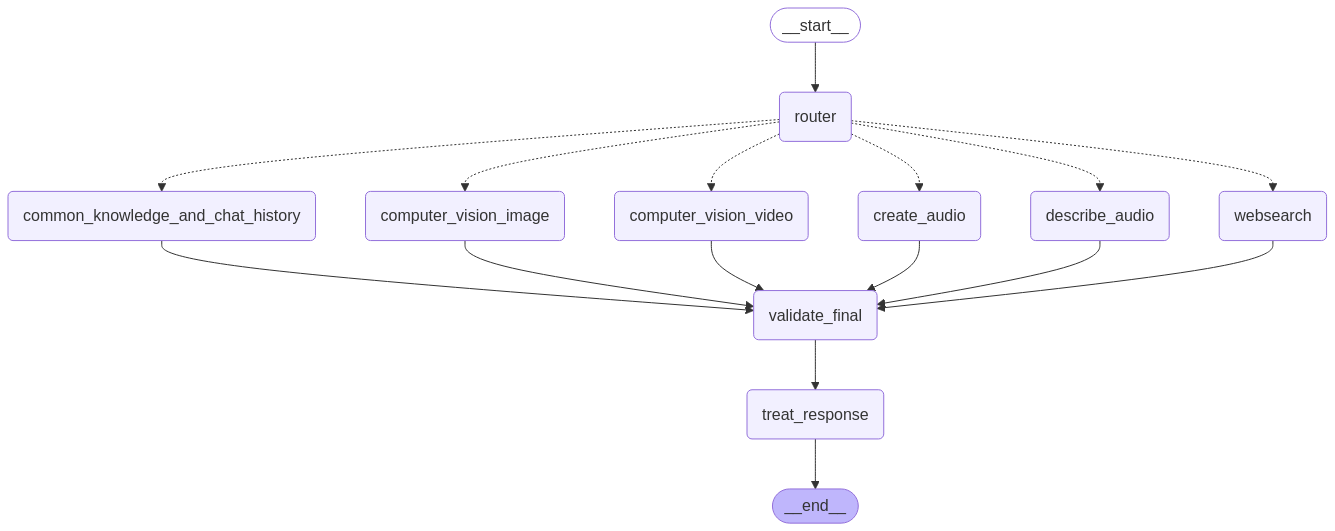

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from pprint import pprint

from langchain_core.messages import SystemMessage
user_id = "1"
config = {"configurable": {"thread_id": "22", "user_id": user_id}}


In [20]:
query = {"messages": [HumanMessage("oi, tudo bem?")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='oi, tudo bem?' additional_kwargs={} response_metadata={} id='e01394c1-2459-4f4d-b8d9-88fe3a01c2ca'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'e01394c1-2459-4f4d-b8d9-88fe3a01c2ca\')]} \n\n        If the user asks for something like news, use the websearch. You must always use the websearch keyword to search on the web in the following format websearch: your_query. Don\'t use quotes in the query.\n        If the user asks for answers about the content in an image, use computer_vision_image.\n        If the user asks about the content in a video, use computer_vision_video.\n        If the user asks fo

In [21]:
query = {"messages": [HumanMessage("tudo bem também")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='tudo bem também' additional_kwargs={} response_metadata={} id='5662d05d-5ccf-48f8-b681-1319a2e0185f'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'e01394c1-2459-4f4d-b8d9-88fe3a01c2ca\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'6851b96b-eecd-45d2-a42b-936ea4402357\'), SystemMessage(content=\'Tudo bem, sim! E você, como está?"\', additional_kwargs={}, response_metadata={}, id=\'72704cf5-788e-4959-b514-35cb439bddae\'), AIMessage(content=\'"yes"\', additional_kwargs={}, response_metadata={}, id=\'5863a2ec-96f6-40c7-b768-97a899b6454a\'

In [22]:
graph.get_state(config).values

{'messages': [HumanMessage(content='oi, tudo bem?', additional_kwargs={}, response_metadata={}, id='e01394c1-2459-4f4d-b8d9-88fe3a01c2ca'),
  SystemMessage(content='"common_knowledge_and_chat_history"', additional_kwargs={}, response_metadata={}, id='6851b96b-eecd-45d2-a42b-936ea4402357'),
  SystemMessage(content='Tudo bem, sim! E você, como está?"', additional_kwargs={}, response_metadata={}, id='72704cf5-788e-4959-b514-35cb439bddae'),
  AIMessage(content='"yes"', additional_kwargs={}, response_metadata={}, id='5863a2ec-96f6-40c7-b768-97a899b6454a'),
  AIMessage(content='content=\'Tudo bem, sim! E você, como está?"\' additional_kwargs={} response_metadata={} id=\'72704cf5-788e-4959-b514-35cb439bddae\'', additional_kwargs={}, response_metadata={}, id='5bab5ad3-2e48-4599-a41a-9d4b5173dbf1'),
  AIMessage(content='Tudo bem, sim! E você, como está?"', additional_kwargs={}, response_metadata={}, id='b18719bb-8773-4d85-a94d-f3d3a1d40541'),
  HumanMessage(content='tudo bem também', additional

In [23]:
query = {"messages": [HumanMessage("queria saber o que tem no áudio que te enviei?")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='queria saber o que tem no áudio que te enviei?' additional_kwargs={} response_metadata={} id='c67cb1b2-5415-4132-9280-b0ea1706f6a8'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'e01394c1-2459-4f4d-b8d9-88fe3a01c2ca\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'6851b96b-eecd-45d2-a42b-936ea4402357\'), SystemMessage(content=\'Tudo bem, sim! E você, como está?"\', additional_kwargs={}, response_metadata={}, id=\'72704cf5-788e-4959-b514-35cb439bddae\'), AIMessage(content=\'"yes"\', additional_kwargs={}, response_metadata={}, id=\'5863a2e

Device set to use cuda:0


LLM started with prompts: ['Human: You are a conversational agent that must answer the user\'s last question about the audio according to the transcription of an audio and the context.\n        Here is the context: [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'e01394c1-2459-4f4d-b8d9-88fe3a01c2ca\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'6851b96b-eecd-45d2-a42b-936ea4402357\'), SystemMessage(content=\'Tudo bem, sim! E você, como está?"\', additional_kwargs={}, response_metadata={}, id=\'72704cf5-788e-4959-b514-35cb439bddae\'), AIMessage(content=\'"yes"\', additional_kwargs={}, response_metadata={}, id=\'5863a2ec-96f6-40c7-b768-97a899b6454a\'), AIMessage(content=\'content=\\\'Tudo bem, sim! E você, como está?"\\\' additional_kwargs={} response_metadata={} id=\\\'72704cf5-788e-4959-b514-35cb439bddae\\\'\', additional_kwargs={}, response_metadata={}, id=\'5bab5ad3-2e48-459

KeyboardInterrupt: 

content='e nessa imagem?' additional_kwargs={} response_metadata={} id='cbfebf6b-e3e2-4127-a894-129e2eb9d751'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'b4d39328-d93f-489c-9006-87db85a89a80\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'b2788e93-7873-4882-bfa7-8e140e236575\'), SystemMessage(content=\'Tudo bem, sim! E você, como está?"\', additional_kwargs={}, response_metadata={}, id=\'82eae7d1-75fc-478b-ac03-9de075c447e6\'), AIMessage(content=\'"yes"\', additional_kwargs={}, response_metadata={}, id=\'19c0584d-684f-4a2d-b3c5-2410202eac52\'
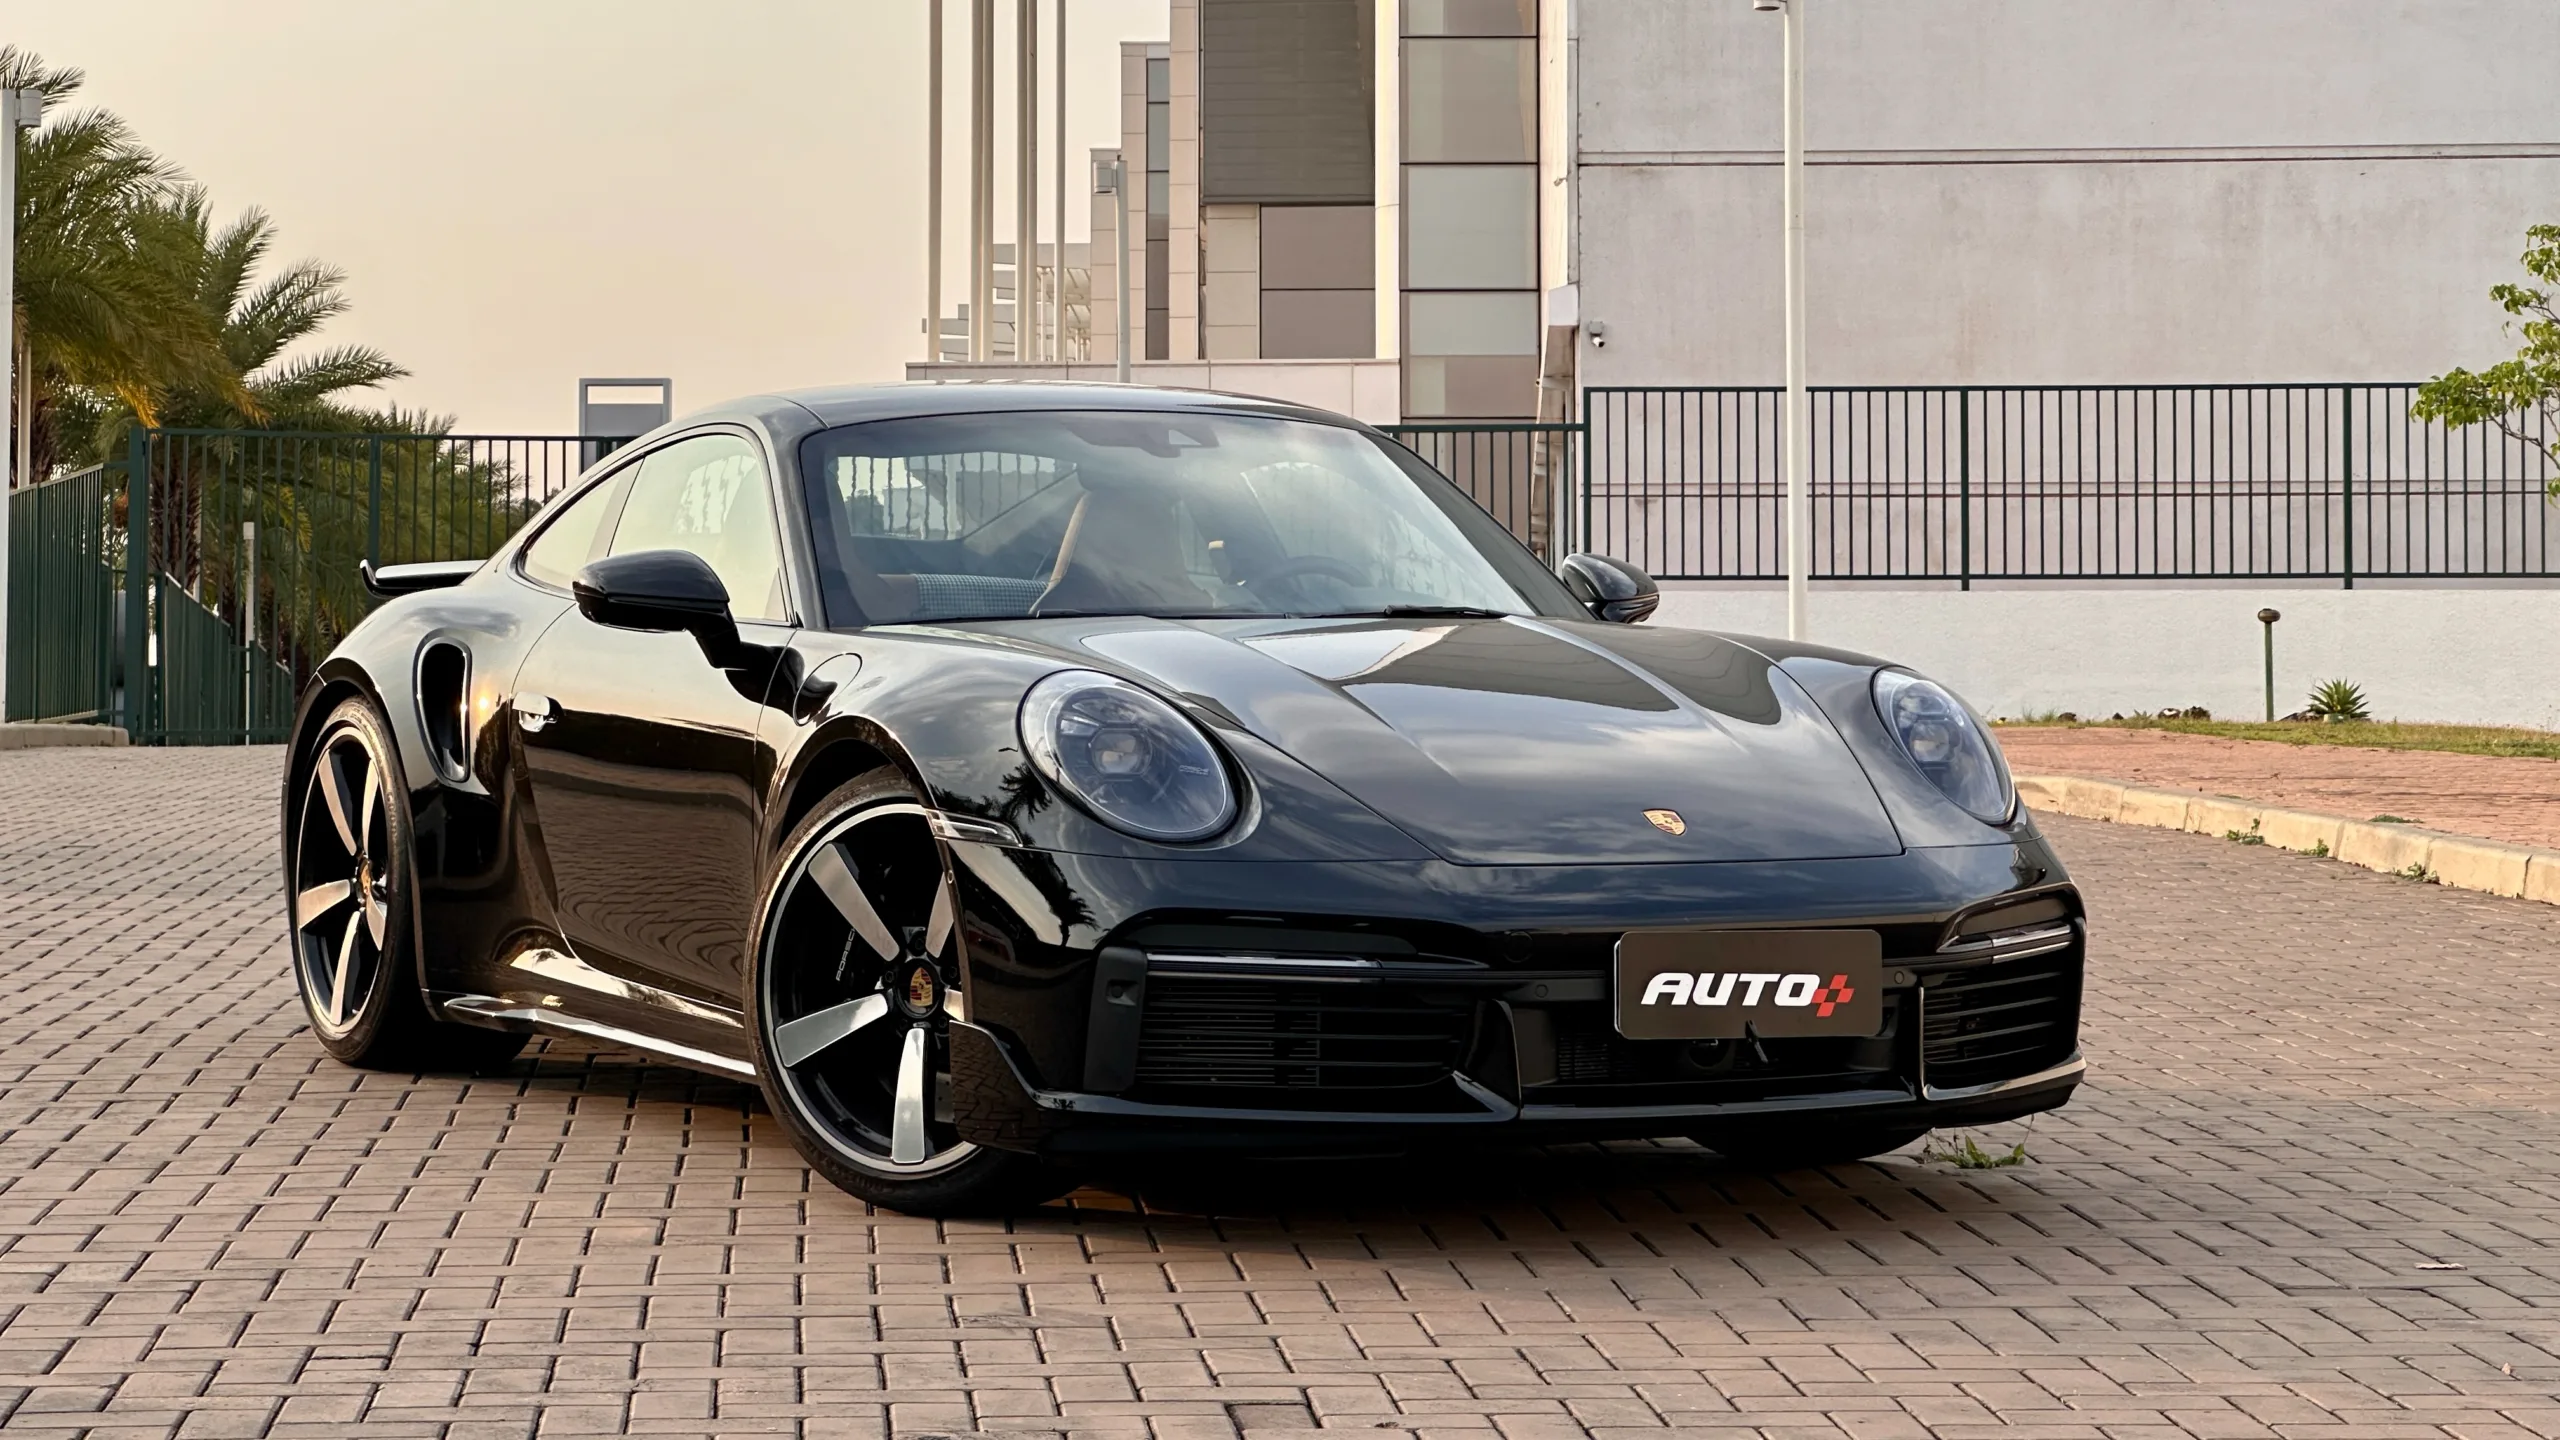

In [ ]:
query = {"messages": [HumanMessage("e nessa imagem?")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

In [ ]:
query = {"messages": [HumanMessage("e nesse vídeo quais são as marcas que aparecem?")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='e nesse vídeo quais são as marcas que aparecem?' additional_kwargs={} response_metadata={} id='ea246353-190a-4c71-957e-bd1f1bb09707'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'b4d39328-d93f-489c-9006-87db85a89a80\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'b2788e93-7873-4882-bfa7-8e140e236575\'), SystemMessage(content=\'Tudo bem, sim! E você, como está?"\', additional_kwargs={}, response_metadata={}, id=\'82eae7d1-75fc-478b-ac03-9de075c447e6\'), AIMessage(content=\'"yes"\', additional_kwargs={}, response_metadata={}, id=\'19c058

In [ ]:
query = {"messages": [HumanMessage("crie pra mim um som de chuva com trovões")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='crie um som de piano junto com uma alarme de carro tocando juntos' additional_kwargs={} response_metadata={} id='19688773-27f6-49a9-aa1d-4868c55eef36'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'872ccdb6-7cca-4ac4-86f8-0dfe0ce078f3\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'1a5b10fa-92f2-4106-984e-2dc8a536615e\'), SystemMessage(content=\'Tudo bem, sim! E você?"\', additional_kwargs={}, response_metadata={}, id=\'3ed190eb-1648-489f-8915-707410d13dbb\'), AIMessage(content=\'"no"\', additional_kwargs={}, response_metadata={}, id=\'

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\baral\anaconda3\envs\ml\Lib\site-packages\torchsde\_brownian\brownian_interval.py:608: UserWarning: Should have tb<=t1 but got tb=500.00006103515625 and t1=500.0.
  warnings.warn(f"Should have {tb_name}<=t1 but got {tb_name}={tb} and t1={self._end}.")
 99%|█████████▉| 198/200 [02:10<00:01,  1.51it/s]c:\Users\baral\anaconda3\envs\ml\Lib\site-packages\torchsde\_brownian\brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.29999998211860657 and t0=0.3.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
100%|█████████▉| 199/200 [02:11<00:00,  1.52it/s]c:\Users\baral\anaconda3\envs\ml\Lib\site-packages\torchsde\_brownian\brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.0 and t0=0.3.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
c:\Users\baral\anaconda3\envs\ml\Lib\site-packages\torchsde\_brownian\brownian_interval.py:602: UserWarning: Should have t

"Output from node 'create_audio':"
'----'
{   'messages': [   SystemMessage(content='O arquivo de áudio que você solicitou, contendo um som de piano junto com uma alarme de carro tocando juntos, foi criado."', additional_kwargs={}, response_metadata={}, id='1880930f-b764-45f1-992e-f0aebb803582')]}
'\n------\n'
messages2:
['user: oi, tudo bem?', 'assistant: "common_knowledge_and_chat_history"', 'assistant: Tudo bem, sim! E você?"', 'user: o que tem no áudio que te enviei?', 'assistant: describe_audio"', 'assistant: No áudio que você enviou, uma pessoa se apresenta como Daniel Baraldi e pergunta se há um Samsung S24 disponível para comprar."', 'user: e nessa imagem?', 'assistant: computer_vision_image"', 'assistant: <|system|>\nA chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user\'s questions.\n<|user|>\n\n"and what\'s in this image?"\n<|assistant|>\nblack car', 'user: de qual marca o carro é?', 'ass

In [ ]:
query = {"messages": [HumanMessage("quais as últimas notícias do z17 da IBM?")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='quais as últimas notícias do z17 da IBM?' additional_kwargs={} response_metadata={} id='e1b4d796-de75-4ff3-adc7-f6988a276d7d'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'quais as últimas notícias do z17 da IBM?\', additional_kwargs={}, response_metadata={}, id=\'e1b4d796-de75-4ff3-adc7-f6988a276d7d\')]} \n\n        If the user asks for something like news, use the websearch. You must always use the websearch keyword to search on the web in the following format websearch: your_query. Don\'t use quotes in the query.\n        If the user asks for answers about the content in an image, use computer_vision_image.\n        If the user asks about the content in a video, u

In [ ]:
query = {"messages": [HumanMessage("faça um resumo do que falamos até agora")]}



for output in graph.stream(query, config):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

content='faça um resumo do que falamos até agora' additional_kwargs={} response_metadata={} id='8e0c2ebb-3626-4ce3-8866-5097767c6195'
LLM started with prompts: ['Human: You are a routing agent that must choose between the following options to answer the user question:\n        "computer_vision_image", "computer_vision_video", "describe_audio", "websearch", "create_audio" or "common_knowledge_and_chat_history" \n \n        Here is the context until now: {\'messages\': [HumanMessage(content=\'oi, tudo bem?\', additional_kwargs={}, response_metadata={}, id=\'872ccdb6-7cca-4ac4-86f8-0dfe0ce078f3\'), SystemMessage(content=\'"common_knowledge_and_chat_history"\', additional_kwargs={}, response_metadata={}, id=\'1a5b10fa-92f2-4106-984e-2dc8a536615e\'), SystemMessage(content=\'Tudo bem, sim! E você?"\', additional_kwargs={}, response_metadata={}, id=\'3ed190eb-1648-489f-8915-707410d13dbb\'), AIMessage(content=\'"no"\', additional_kwargs={}, response_metadata={}, id=\'19682a44-72ff-496e-b1c2-12